# Приоритизация гипотез и анализ A/B-теста

В двух частях данной работы будут приоритизированы 9 гипотез по увеличению выручки интернет-магазина и проведен анализ A/B-теста

**Цель исследования**:
Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**Этапы исследования:**
1. Изучение данных и подготовка их к анализу 
2. Приоритизация гипотез \
    2.1. Применение фреймворка ICE для приоритизации гипотез.  
    2.2. Применение фреймворка RICE  для приоритизации гипотез.  
3. Анализ A/B-теста  
    3.1. Построение графика кумулятивной выручки по группам.  
    3.2. Построение графика кумулятивного среднего чека по группам  
    3.3. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A  
    3.4. Построение графика кумулятивного среднего количества заказов на посетителя по группам  
    3.5. Построение графика относительного изменения кумулятивного среднего кол-ва заказов на посетителя группы B к группе A.   
    3.6. Построение точечного графика количества заказов по пользователям  
    3.7. Расчёт 95-й и 99-й перцентили кол-ва заказов на пользователя. Выбор границы для определения аномальных пользователей   
    3.8. Построение точечного графика стоимостей заказов.  
    3.9. Расчёт 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.  
    3.10.Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.  
    3.11.Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным  
    3.12.Расчёт статистической значимости различий в среднем кол-ве заказов на посетителя между группами по «очищенным» данным  
    3.13.Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным  
    3.14.Принятие решения по результатам теста  

## Изучение данных и подготовка их к анализу

Импортируем библиотеки, загрузим данные.

In [1]:
#импорт библиотек
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
#загрузка данных
try:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('/datasets/orders.csv'),  # заказы
    pd.read_csv('/datasets/visitors.csv')  # пользователи
)
except:
    hypothesis, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),  # заказы
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')  # пользователи
)

### Изучим данные
Проверим:
- верно ли названы колонки
- соответствуют ли типы данных в колонках значениям
- есть ли в данных пропуски и дубликаты.

In [3]:
pd.options.display.max_colwidth = 100

for i in [hypothesis, orders, visitors]:
    print()
    print('Первые строки таблицы:')
    print(i.head());
    print()
    print('Основная информация о таблице:')
    print(i.info());
    print()
    print('Описание столбцов таблицы:')
    print(i.describe());
    print()
    print('Проверка таблицы на пропуски:')
    print(i.isna().sum());
    print()
    print('Проверка таблицы на дубликаты:')
    print(i.duplicated().sum());
    print('-'*50)


Первые строки таблицы:
                                                                                            Hypothesis  \
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                     Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

   Reach  Impact  Confidence  Efforts  
0      3      10           8        6  
1      2       5           4       10  
2      8       3           7        3  
3      8       3           3        8  
4      3       1           1        1  

Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8

### Выполним предобработку
- В таблице hypothesis приведем названия столбцов в нижнему регистру  
- В таблице orders поменяем названия стоблцов transactionId и visitorId на transaction_id и visitor_id  
- В таблицах orders и visitors столбец date приведем к типу  datetime   
- После этого проверим совпадают ли диапазоны дат    
- Кроме этого, проверим, пересекаются ли пользователи в двух группах А и В. 

In [4]:
#изменение регистра в названиях столбцов 
hypothesis.columns = hypothesis.columns.str.lower()

#изменение названия столбцов таблицы orders
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}) 

# приведение столбца date к типу datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [5]:
#проверка диапазонов дат таблиц orders и visitors
print('Описание столбца date таблицы orders')
print(orders['date'].describe(datetime_is_numeric=True))
print()
print('Описание столбца date таблицы visitors')
visitors['date'].describe(datetime_is_numeric=True)

Описание столбца date таблицы orders
count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

Описание столбца date таблицы visitors


count                     62
mean     2019-08-16 00:00:00
min      2019-08-01 00:00:00
25%      2019-08-08 06:00:00
50%      2019-08-16 00:00:00
75%      2019-08-23 18:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

В таблицах заказов и посетителей рассматриваются события с 01 по 31 августа 2019г.

In [6]:
# пользователи, которые попали в обе группы теста 
group_nunique = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
len(group_nunique.query('group > 1'))

58

58 пользователей попали в обе группы теста. Таких пользователей необходимо исключить из анализа, но так как в таблице visitors нет данных visitor_id, убрать таких пользователей не можем. 

### Выводы по этапу предобработки данных

Мы выполнили предобработку данных таблиц hypothesis, orders, visitors:
    
- названия столбцов таблиц изменили в соотвествии с правилами хорошего стиля
- в таблицах orders и visitors столбец date привели к типу  datetime   
- сделали проверку диапазонов дат таблиц с пользователями и заказами     
- сделали проверку пересечения пользователей в тестовых группах и выявили 58 таких юзеров. 

## Часть 1. Приоритизация гипотез

In [7]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Применение фреймворка ICE для приоритизации гипотез.
Отсортируем гипотезы по убыванию приоритета.

In [8]:
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round()
hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


4 наиболее перспективные гипотезы по ICE: 8, 0, 7, 6

### Применение фреймворка RICE для приоритизации гипотез.
Отсортируем гипотезы по убыванию приоритета.

In [9]:
hypothesis['rice'] = (hypothesis['reach']  * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


4 наиболее перспективные гипотезы по RICE: 7, 2, 0, 6

### Изменение приоритизации гипотез при применении RICE вместо ICE.

In [10]:
hypothesis[['hypothesis','ice', 'reach','rice']].sort_values(by='rice', ascending=False)

,hypothesis,ice,reach,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0,10,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.0,8,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0,3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.0,5,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0,1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0,8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,2,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0,3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3,3.0


**Вывод по приоритизации гипотез**  
Наиболее перспективные гипотезы по фреймворку ICE и RICE отличаются: 
- наиболее перспективные гипотезы по ICE:  8, 0, 7, 6  
- наиболее перспективные гипотезы по RICE: 7, 2, 0, 6

Разные позиции гипотез по ICE и RICE связаны с тем, что параметр reach (охват пользователей) фреймворка RICE для гипотез 7 и 2 наиболее высокий (10 и 8 соответственно).   

Стоит отметить, что наиболее перспективная гипотеза по ICE - 8, имеет самый маленький охват (равный 1), поэтому при применении фреймворка RICE у гипотезы только 5-ое место.     

Гипотеза 4 в обих случаях имеет наименьшую оценку приоритизации.

## Часть 2. Анализ A/B-теста

In [11]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# Определим группы теста
print('Группы А/В теста:', orders['group'].unique())

Группы А/В теста: ['B' 'A']


In [14]:
a_group = len(orders.query('group == "A"')['visitor_id'].unique())
b_group = len(orders.query('group == "B"')['visitor_id'].unique())

print('Пользователей в группе А:', a_group)
print('Пользователей в группе B:', b_group)
print('Разница в количестве посетителей в выборках составляет:', round((1-a_group/b_group)*100,2),'%')

Пользователей в группе А: 503
Пользователей в группе B: 586
Разница в количестве посетителей в выборках составляет: 14.16 %


- А/В тест парный, в тесте 2 группы: сегмент А сравниваем с сегментом В.
- как мы выясняли ранее на этапе предобработки, тест проводится с 01 по 31 августа 2019г. Запланированные даты проведения теста не даны. 
- По количеству пользователей, группы отличаются на 14,16%

### График кумулятивной выручки по группам
Соберем кумулятивные данные. Создадим датафрейм cumulative_data c агрегированными кумулятивными по дням данными о заказах и посетителях

In [15]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


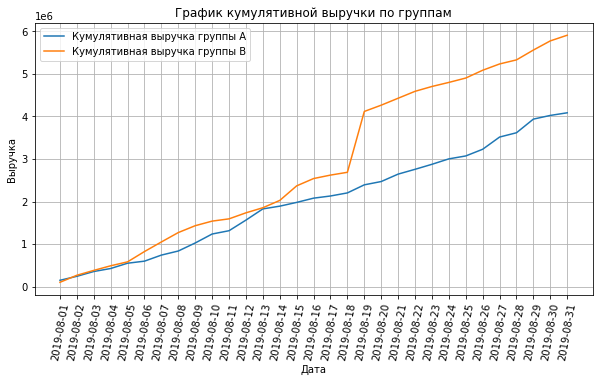

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,5))
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='Кумулятивная выручка группы A')
# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='Кумулятивная выручка группы B')
plt.title('График кумулятивной выручки по группам')
plt.grid()
plt.xticks(cumulative_revenue_a['date'], rotation=80)
plt.xlabel('Дата')
plt.ylabel('Выручка');
plt.legend();

**Вывод:**  
- Выручка групп увеличивается в течение всего теста.  
- В первые 5 дней месяца кумулятивная выручка группы А и В были сопоставимы.   
- С 05 по 13 августа кумулятивная выручка группы В растет быстрее, но показатель группы А выравнивается к 13 августа.  
- Во второй половине месяца наблюдаем резкий рост графика группы В, особенно 19 августа. Это может сигнализировать о всплесках числа заказов, либо о появлении дорогих заказов в выборке В.

По итогу месяца видим, что кумулятивная выручка группы A больше кумулятивной выручки группы В

### График кумулятивного среднего чека по группам

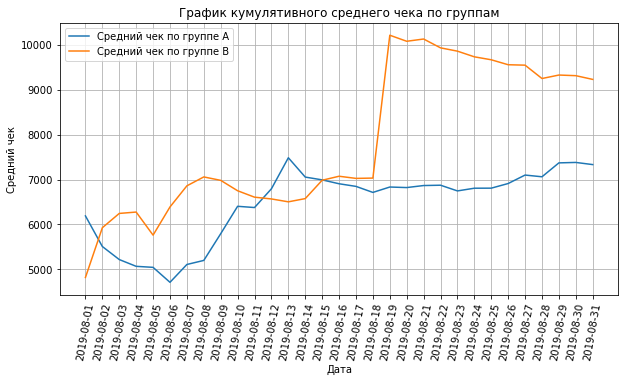

In [17]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], 
         label='Средний чек по группе A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], 
         label='Средний чек по группе В')
plt.title('График кумулятивного среднего чека по группам')
plt.grid()
plt.xticks(cumulative_revenue_a['date'], rotation=80)
plt.xlabel('Дата')
plt.ylabel('Средний чек');
plt.legend();

**Вывод:**  

- Средний чек группы А был больше среднего чека группы В только в начале месяца и c 12 по 14 августа.
- В остальные периоды кумулятивный средний чек по группе В был больше. 
- Средний чек обеих групп имеет колебания и становится более равномерным после 19 августа.
- В группу В 19 августа попали крупные заказы, которые на графике видны как резкий рост показателя.  
После этой даты средний чек для группы B начал постепенно снижаться. 
- У группы А средний чек с 18 августа постепенно растет 

### График относительного изменения кумулятивного среднего чека группы B к группе A

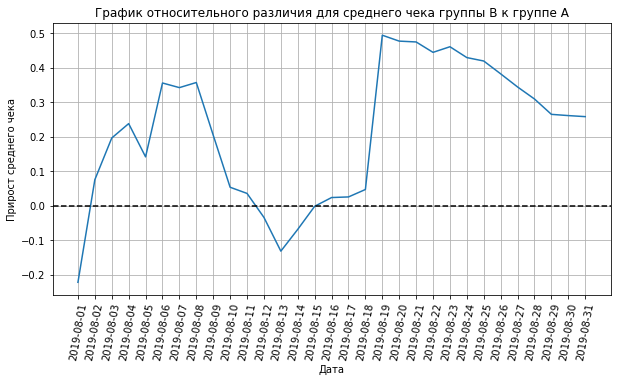

In [18]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
plt.figure(figsize=(10,5))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

# добавляем горизонтальную ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного различия для среднего чека группы B к группе A')
plt.grid()
plt.xticks(cumulative_revenue_a['date'], rotation=80)
plt.xlabel('Дата')
plt.ylabel('Прирост среднего чека');

**Вывод:**

Практически весь период средний чек группы В больше среднего чека группы А:
- Средний чек группы В превысил средний чек группы А со 2ого дня теста и рос относительно второй группы до 08 августа. 
- С 08 по 13 августа показатель группы В снижался, из-за чего с 12 по 14 августа средний чек А превышал средний чек В. 
- Далее средний чек группы В снова пошел в рост, а 18-19 августа наблюдается резкий скачок среднего чека относительно группы А.
- После этого средний чек группы В постепенно снижался  

В нескольких точках график различия между сегментами резко колеблется, что, как и в других рассмотренных графиках, сигнализирует о наличии выбросов. 

### График кумулятивного среднего количества заказов на посетителя по группам

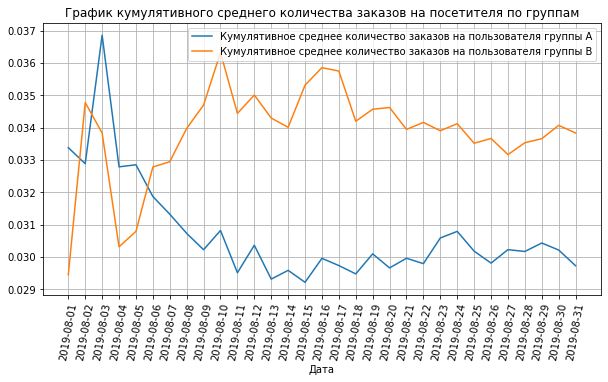

In [19]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='Кумулятивное среднее количество заказов на пользователя группы A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='Кумулятивное среднее количество заказов на пользователя группы В')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.grid()
plt.xticks(cumulative_revenue_a['date'], rotation=80)
plt.xlabel('Дата');

**Вывод:**  

В начале теста показатель кумулятивного среднего количества заказов на посетителя группы А была выше, чем у  В и 03 августа достигла максимального значения 0.37, однако затем кумулятивное среднее группы постепенно снизилось и к концу теста установилось в районе значения 0.030.  

Кумулятивное среднее количества заказов на посетителя группы В с 06 августа вырвалось вперёд и до конца теста стабильно превышает группу А. 
К концу теста значения сегмента В установились в пределах 0.033-0.034 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

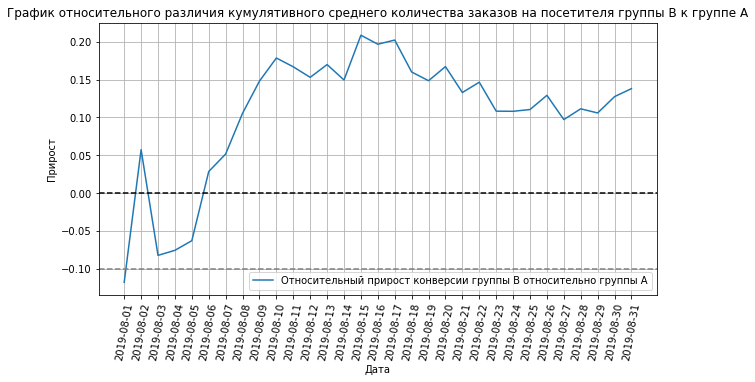

In [20]:
# Объединим таблицы cumulative_data_a и cumulative_data_b, чтобы она содержала столбцы: ['date', 'conversionA', 'conversionB']
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# Построим график относительного различия кумулятивной конверсии группы B к группе A.
plt.figure(figsize=(10,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('График относительного различия кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.grid()
plt.xticks(merged_cumulative_conversions['date'],rotation=80)
plt.xlabel('Дата')
plt.ylabel('Прирост');
# Добавим пунктирную линию оси X чёрного цвета ('black') со значением оси Y = 0 методом plt.axhline()
plt.axhline(y=0, color='black', linestyle='--')

# Добавим ещё одну линию оси X серого цвета ('grey') со значением оси Y = 0.1
plt.axhline(y=-0.1, color='grey', linestyle='--');

**Вывод:** 

- В начале теста относительное изменение кумулятивного среднего количества заказов на посетителя сегмента В была ниже, чем у сегмента А. Был прирост 02 августа со снижением значения в следующий день.  
- С 03 августа показатель сегмента В начал расти и с 06 августа стал стабильно превышать группу А
- Прирост был максимальным 15 и 17 августа, в районе 20% 
- После этого график начал снижаться и к концу теста находится в диапазоне 10-15% выше группы А 

### Точечный график количества заказов по пользователям

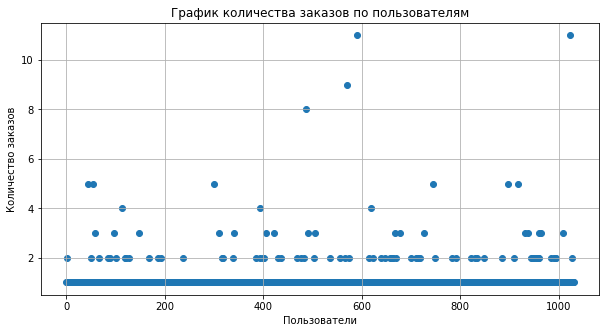

In [21]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['user_id', 'orders']

x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders_by_users['orders']) 
plt.grid()
plt.title('График количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show();

**Вывод:**  

По графику количества заказов видим, что в основном пользователи делают 1-2 заказа. 

Более 3х заказов немного, но для того, чтобы понять является ли такое количество аномальным, посчитаем выборочные перцентили количества заказов на одного пользователя. 

### Расчёт 95-й и 99-й перцентили количества заказов на пользователя
Выбор границы для определения аномальных пользователей.

In [22]:
orders_percent_5 = np.percentile(orders_by_users['orders'], 95)
orders_percent_1 = np.percentile(orders_by_users['orders'], 99)

print('95-й перцентиль количества заказов на пользователя = {} \n99-й перцентиль количества заказов на пользователя = {}'.format(orders_percent_5, orders_percent_1)) 

95-й перцентиль количества заказов на пользователя = 2.0 
99-й перцентиль количества заказов на пользователя = 4.0


**Вывод:**   
Только 1% пользователей делают более 4х заказов и не более 5% пользователей делали более 2х заказов. 
Установим 2 заказа на пользователя за верхнюю границу числа заказов, и отсеим аномальных пользователей по ней. 

### Точечный график стоимостей заказов

In [23]:
orders['revenue'].max()

1294500

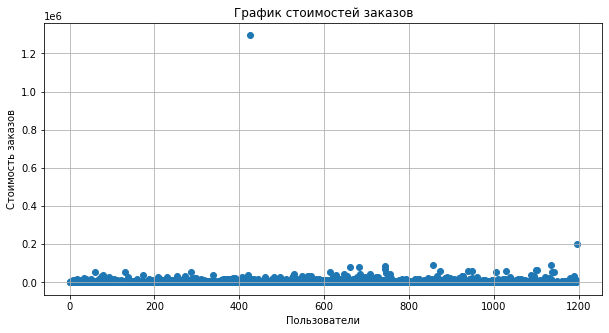

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show();

**Вывод:** 

На графике стоимостей заказов видим 2 явных аномальных значения - 1 294 500 и 200 000.  
Определим 95 и 99 перцентили среднего чека в выборке, чтобы далее отсеять от 1% до 5% наблюдений с крайними значениями

Построим график без учета двух крупных заказов и исследуем распределение других покупок

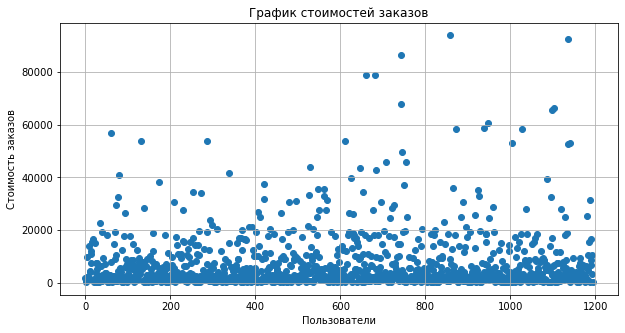

In [25]:
other_orders = orders[orders['revenue']< 200000]['revenue']

other_orders_values = pd.Series(range(0,len(other_orders)))
plt.figure(figsize=(10,5))
plt.scatter(other_orders_values, other_orders) 
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show();

Как видим по графику, большинство заказов стоили менее 20 000р. Реже встречаются заказы от 20 000 до 60 000р. Какие значения считать выбросами не ясно, поэтому рассчитаем 95 и 99 процентили и определим границы аномальных заказов

### Расчёт 95-й и 99-й перцентили стоимости заказов
Выбор границы для определения аномальных заказов.

In [26]:
revenue_percent_5 = np.percentile(orders['revenue'], 95)
revenue_percent_1 = np.percentile(orders['revenue'], 99)

print('95-й перцентиль стоимости заказов на пользователя = {} \n99-й перцентиль стоимости заказов на пользователя = {}'.format(revenue_percent_5, revenue_percent_1)) 

95-й перцентиль стоимости заказов на пользователя = 28000.000000000004 
99-й перцентиль стоимости заказов на пользователя = 58233.19999999999


**Вывод:**  
Не более 5% заказов дороже 28 000 у.е и не более 1% дороже 58 233 у.е.   
В качестве границы для определения аномальных заказов возьмем 99-й перцентиль

### Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
#### Подготовка «сырых» данных

Для проверки гипотез применим непараметрический тест Уилкоксона-Манна-Уитни.

Метод работает с номерами значений в упорядоченном ряду, не учитывая сами значения. 
Это удобно, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты. 

Возьмем стандартное значение значимости в 5% (alpha = 0.05)

Сформулируем гипотезы:
- Нулевая: различий в среднем количестве заказов между группами нет.   
- Альтернативная: различия в среднем между группами есть.

In [27]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

print(visitors_a_daily.head())
print(visitors_b_daily.head())

        date  visitors_per_date_a
0 2019-08-01                  719
1 2019-08-02                  619
2 2019-08-03                  507
3 2019-08-04                  717
4 2019-08-05                  756
         date  visitors_per_date_b
31 2019-08-01                  713
32 2019-08-02                  581
33 2019-08-03                  509
34 2019-08-04                  770
35 2019-08-05                  707


Создадим переменные orders_by_users_a и orders_by_users_b со столбцами 'user_id', 'orders', где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. 

In [28]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

print(orders_by_users_a.head())
print(orders_by_users_b.head())

    user_id  orders
0   8300375       1
1  11685486       1
2  54447517       1
3  66685450       1
4  78758296       1
    user_id  orders
0   5114589       1
1   6958315       1
2   8300375       1
3  39475350       1
4  47206413       1


Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя (пользователям без заказов — нули).   

В sampleA и sampleB сохраним выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль.   
В таком случае:
- сумма всех элементов — количество заказов. 
- число элементов — это количество пользователей, 

In [29]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a_daily['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b_daily['visitors_per_date_b'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Расчёт статистической значимости 
Применим критерий и отформатируем p-value. Порогом статистической значимости установим alpha=.05. 
Округлим до трёх знаков после запятой. 

Найдём среднее число заказов на пользователя в выборках методом mean().
Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. 
Округлим до трёх знаков после запятой. 

In [30]:
alpha = 0.05

print('Порог статистической значимости alpha =', alpha)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Относительный прирост среднего числа заказов группы B: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

Порог статистической значимости alpha = 0.05
p-value = 0.020
Относительный прирост среднего числа заказов группы B: 0.133


**Вывод**:  

P-value меньше 0.05, значит нулевую гипотезу отвергаем. 
В среднем количестве заказов на посетителя между группами по «сырым» данным есть различия.

Относительный выигрыш группы B равен 13.8%

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Для расчёта статистической значимости различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. Также найдём относительные различия в среднем чеке между группами

- Нулевая гипотеза: различий в среднем чеке между группами нет.   
- Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Порог статистической значимости alpha= 0.05 

In [31]:
print('Порог статистической значимости alpha =', alpha)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия в среднем чеке между группами А и В {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Порог статистической значимости alpha = 0.05
p-value = 0.729
Относительные различия в среднем чеке между группами А и В 0.259


**Вывод:**  
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.   Относительное различие между чеками 25,9%

### Расчёт статистической значимости различий в среднем кол-ве заказов на посетителя между группами по «очищенным» данным
#### Подготовка «очищенных» данных

Для дальнейшего расчета показателей по данным без аномальных значений подготовим срезы пользователей.

Ранее мы определили следующие границы для определения аномальных значений:
1. Пользователи, у которых более 2х заказов (users_with_many_orders)
2. Заказы дороже 58 233 у.е. (users_with_expensive_orders)  

Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами.   
Объединим их в таблице abnormalUsers и посчитаем количество таких пользователей 

In [32]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > orders_percent_5]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > orders_percent_5]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > revenue_percent_1]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print()
print('Всего пользователей:', len(orders['visitor_id'].unique())) 
print('Всего аномальных пользователей:', abnormal_users.shape[0]) 
print('Аномальные пользователи в относительном выражении: {:.02%}'.format(abnormal_users.shape[0]/len(orders['visitor_id'].unique()))) 


1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64

Всего пользователей: 1031
Всего аномальных пользователей: 31
Аномальные пользователи в относительном выражении: 3.01%


Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [33]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a_daily['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b_daily['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

#### Расчёт статистической значимости
**Применим статистический критерий Манна-Уитни к полученным выборкам**

Нулевая гипотеза: статистически значимых различий в конверсии между группами нет.
Альтернативная гипотеза: статистически значимые различия есть.

In [34]:
print('Порог статистической значимости alpha =', alpha)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост среднего числа заказов группы В: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

Порог статистической значимости alpha = 0.05
p-value = 0.010
Относительный прирост среднего числа заказов группы В: 0.174


**Вывод:**  
P-value меньше 0.05, значит нулевую гипотезу отвергаем. 
В среднем количестве заказов на посетителя (конверсии) между группами по «очищенным» данным есть различия.

Относительный выигрыш группы B равен 17.4%, то есть сегмент В лучше сегмента А.

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Посмотрим результаты по «очищенным» данным по среднему чеку.

Нулевая гипотеза: статистически значимых различий в среднем чеке между группами нет.
Альтернативная гипотеза: различия в среднем чеке между группами есть.
Порог статистической значимости alpha= 0.05

Для расчёта статистической значимости различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. Также найдём относительные различия в среднем чеке между группами

In [35]:
print('Порог статистической значимости alpha =', alpha)

print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительные различия в среднем чеке между группами В к А = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Порог статистической значимости alpha = 0.05
p-value = 0.798
Относительные различия в среднем чеке между группами В к А = -0.020


**Вывод:**

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. После удаления выбросов относительное различие между чеками изменилось: средний чек группы В стал на 2% ниже среднего чека группы А.

### Принятие решения по результатам теста
- Есть статистически значимое различие по конверсии между группами по «сырым» и «очищенным» данным.
Относительный выигрыш группы "B" над "A" по "сырым" данным составляет 13,3%, по очищенным данным - 17,4%.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после исключения аномалий
Относительные различия в среднем чеке между группами в сырых данных составляло 25,9%, а после фильтрации аномалий, средний чек сегмента В стал на 2% ниже среднего чека сегмента А

- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и имеют тенденцию к росту
- График различия среднего чека колеблется. График позволил увидеть аномалии. 

**Исходя из обнаруженных фактов**: \
    • тест можно остановить и признать успешным. \
    • группа В лучше группы А по конверсии, а по среднему чеку сегменты практически не отличаются